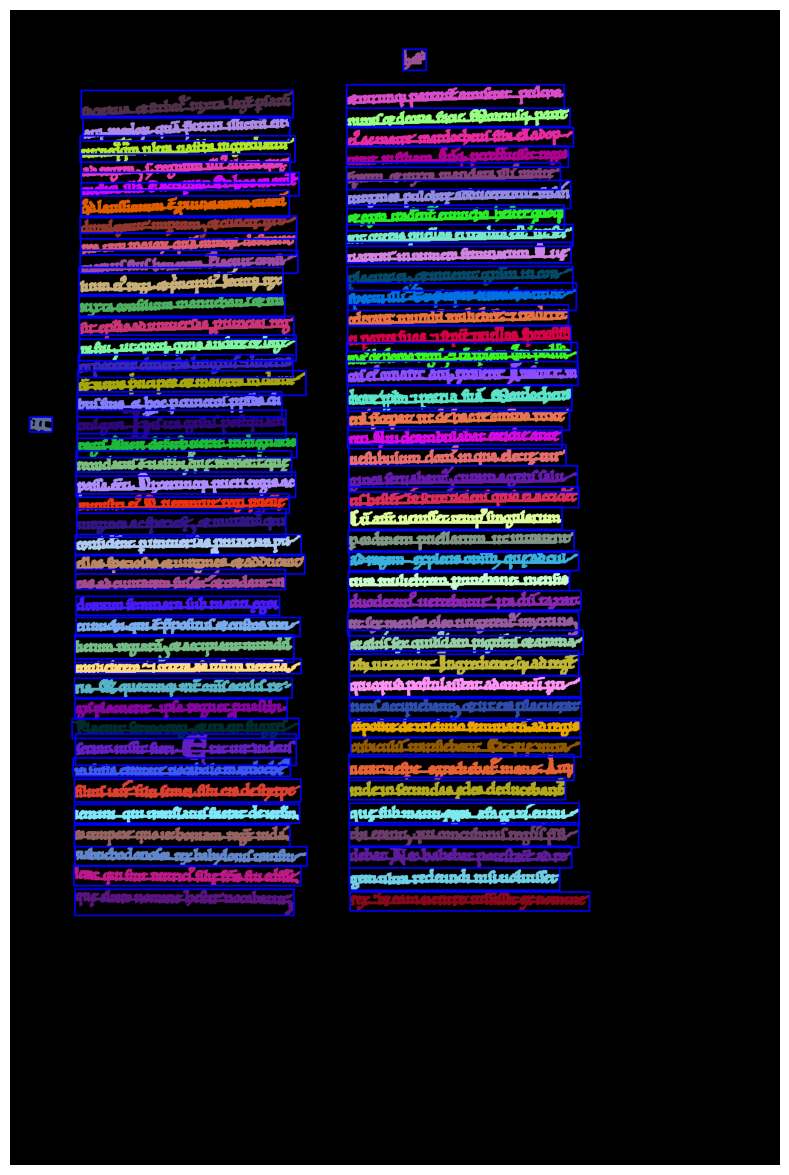

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

mask = cv2.imread("./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/034.png", cv2.IMREAD_GRAYSCALE)
binary = (mask > 127).astype(np.uint8)

n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)

colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]

colored_labels = colors[labels]
colored_labels = colored_labels.astype(np.uint8)

for i in range(1, n_labels):
    x, y, w, h, area = stats[i]
    cv2.rectangle(colored_labels, (x, y), (x + w - 1, y + h - 1), (255, 0, 0), 2)

colored_labels_rgb = cv2.cvtColor(colored_labels, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(colored_labels_rgb)
plt.axis('off')
plt.show()

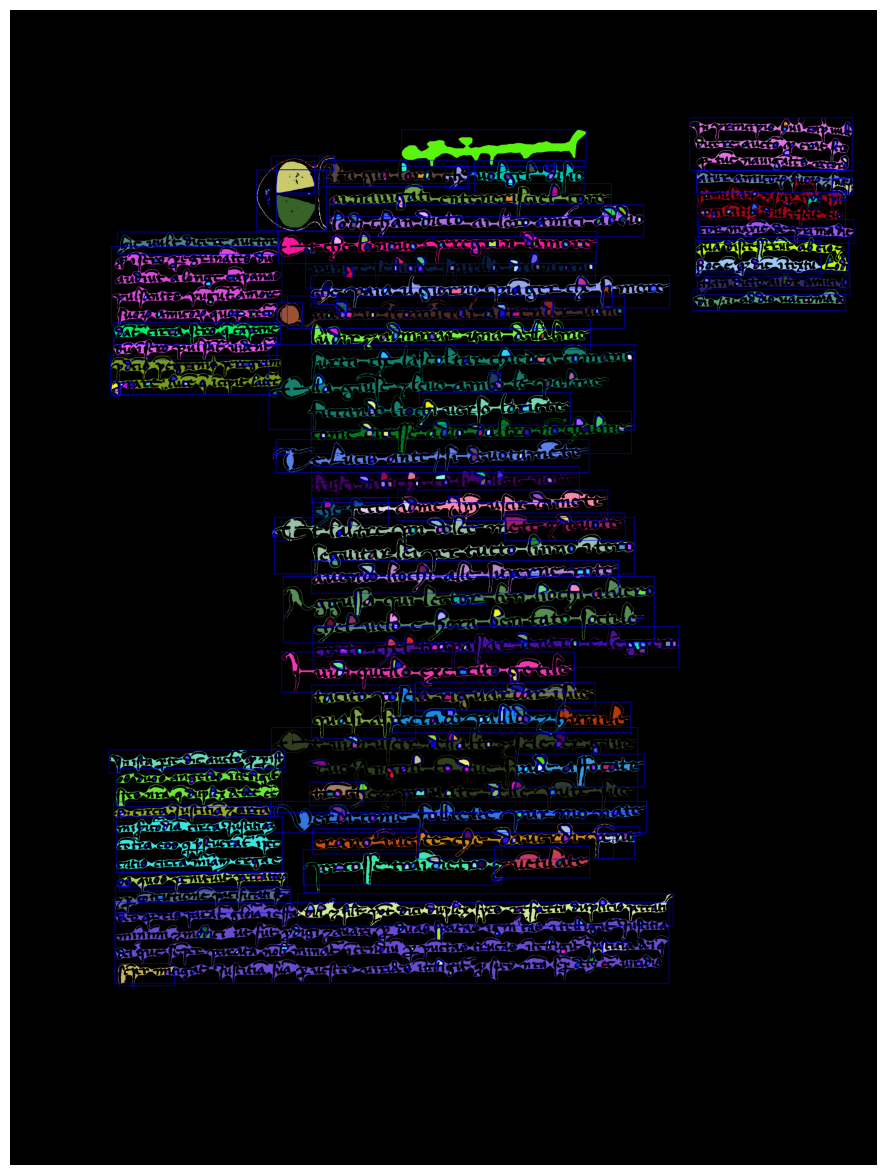

In [2]:
mask = cv2.imread("./data/DIVA-HIsDB/pixel-level-gt-CB55/pixel-level-gt/public-test/e-codices_fmb-cb-0055_0098v_max.png", cv2.IMREAD_GRAYSCALE)
binary = (mask > 0).astype(np.uint8)

n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)

colors = np.random.randint(0, 255, size=(n_labels, 3), dtype=np.uint8)
colors[0] = [0, 0, 0]

colored_labels = colors[labels]
colored_labels = colored_labels.astype(np.uint8)

for i in range(1, n_labels):
    x, y, w, h, area = stats[i]
    cv2.rectangle(colored_labels, (x, y), (x + w - 1, y + h - 1), (255, 0, 0), 2)

colored_labels_rgb = cv2.cvtColor(colored_labels, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(colored_labels_rgb)
plt.axis('off')
plt.show()

In [3]:
input_dir = "./data/U-DIADS-TL/Latin14396/img-Latin14396/test/"
output_dir = "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test_pred2/"

os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.lower().endswith('.jpg'):
        img_path = os.path.join(input_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary = 255 - binary  # invert

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 3))
        binary_closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

        n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_closed)

        line_mask = (labels > 0).astype('uint8') * 255
        base_name = os.path.splitext(filename)[0]
        cv2.imwrite(os.path.join(output_dir, base_name + ".png"), line_mask)


from utils.eval_report import evaluate_text_line_segmentation

evaluate_text_line_segmentation(
    "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test/",
    "./data/U-DIADS-TL/Latin14396/text-line-gt-Latin14396/test_pred2/"
)

Evaluating images: 100%|██████████| 15/15 [00:00<00:00, 24.10it/s]


Final Evaluation Metrics:
Pixel IoU: 0.6713
Line IoU: 0.2592
Detection Rate (DR): 0.6107
Recognition Accuracy (RA): 0.3091
F-Measure (FM): 0.4064


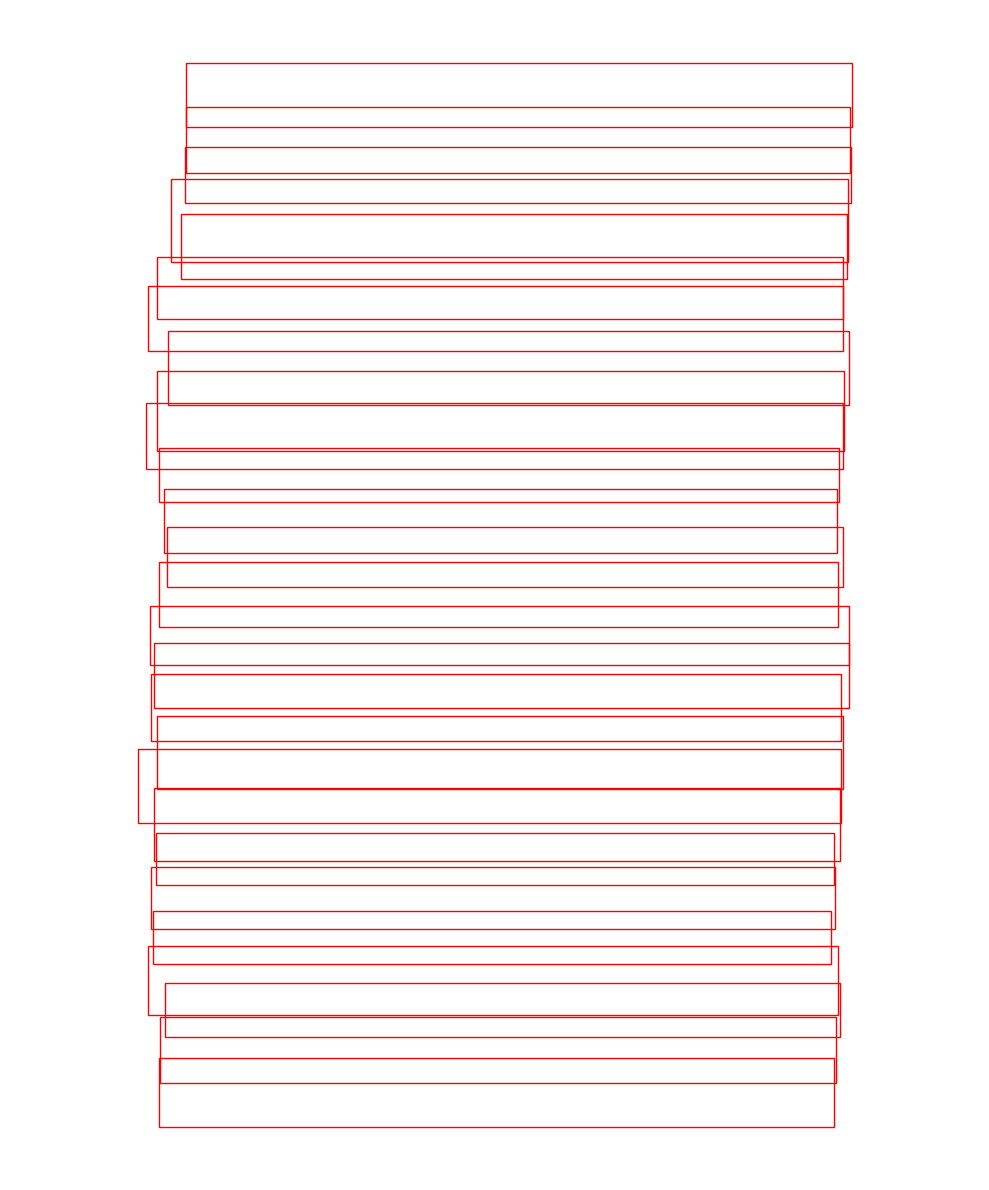

In [2]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re

def parse_line_bounding_boxes(xml_path):
    """
    Parses a PAGE XML file to extract the bounding box coordinates for each TextLine.
    A bounding box is the smallest rectangle enclosing the line's polygon.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Automatically detect the namespace from the root tag to make the code general
    namespace_match = re.match(r'\{.*\}', root.tag)
    ns = {}
    if namespace_match:
        # The namespace is found in the format {http://schema.primaresearch.org/...}
        ns['pc'] = namespace_match.group(0).strip('{}')

    bounding_boxes = []

    # Find all TextLine elements using the detected namespace
    for line in root.findall(".//pc:TextLine", ns):
        coords_el = line.find("pc:Coords", ns)
        if coords_el is not None:
            coords = coords_el.get("points")
            if coords:
                # Convert the string of points into a list of (x, y) tuples
                points = [tuple(map(int, p.split(','))) for p in coords.strip().split()]
                
                # --- MODIFICATION: Calculate the bounding box ---
                if points:
                    # Unzip the list of tuples into two lists: one for x and one for y
                    xs, ys = zip(*points)
                    
                    # Find the min and max coordinates
                    min_x = min(xs)
                    min_y = min(ys)
                    max_x = max(xs)
                    max_y = max(ys)
                    
                    # Append the bounding box (min_x, min_y, max_x, max_y) to our list
                    bounding_boxes.append((min_x, min_y, max_x, max_y))

    return bounding_boxes

def plot_bounding_boxes(bboxes):
    """
    Plots rectangular bounding boxes from a list of coordinates.
    """
    # Create a figure and axes for plotting
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # --- MODIFICATION: Plot rectangles instead of polygons ---
    for box in bboxes:
        min_x, min_y, max_x, max_y = box
        
        # Calculate the width and height of the rectangle
        width = max_x - min_x
        height = max_y - min_y
        
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (min_x, min_y), 
            width, 
            height, 
            linewidth=1, 
            edgecolor='red', 
            facecolor='none'
        )
        
        # Add the rectangle to the axes
        ax.add_patch(rect)

    ax.invert_yaxis()
    plt.axis('equal')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- To run this code ---
# 1. Save the XML data you provided into a file named 'page.xml'.
# 2. Place 'page.xml' in the same directory as this script.
xml_file = "../RQ3/vml-ahte_dataset/ahte_test_ground_xml/moc_test_10.xml"
bboxes = parse_line_bounding_boxes(xml_file)
plot_bounding_boxes(bboxes)